In [54]:
using SparseIR
using PyPlot
using LinearAlgebra

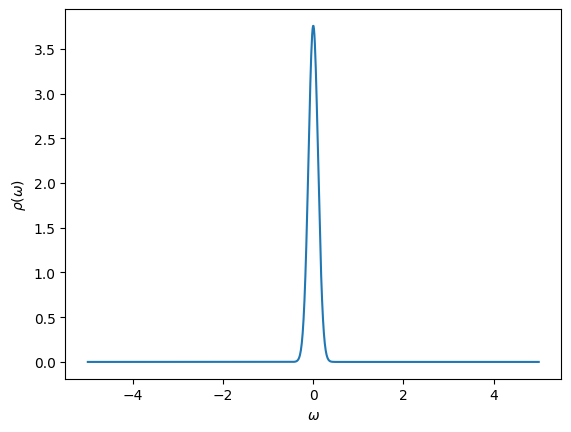

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x14dc71ba8f70>

In [2]:
# Three Gaussian peaks (normalized to 1)
gaussian(x, mu, sigma) = exp(-((x-mu)/sigma)^2)/(sqrt(π)*sigma)

#rho(omega) = 0.2*gaussian(omega, 0.0, 0.15) + 
#    0.4*gaussian(omega, 1.0, 0.8) + 0.4*gaussian(omega, -1.0, 0.8)

rho(omega) = gaussian(omega, 0.0, 0.15)
#    0.4*gaussian(omega, 1.0, 0.8) + 0.4*gaussian(omega, -1.0, 0.8)

omegas = LinRange(-5, 5, 1000)
plt.xlabel(L"\omega")
plt.ylabel(L"\rho(\omega)")
plt.plot(omegas, rho.(omegas))

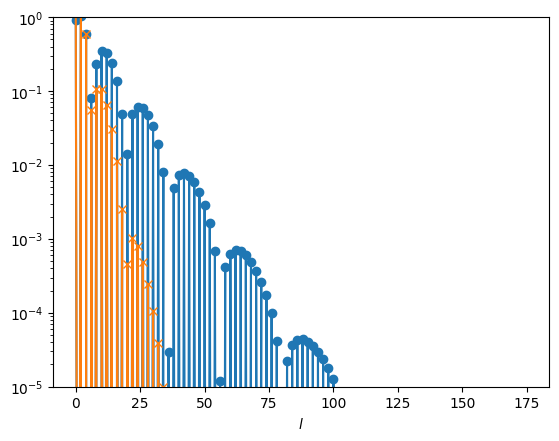

(1.0e-5, 1.0)

In [3]:
beta = 100
wmax = 1000
IR_basis_set = FiniteTempBasisSet(beta, wmax, 1e-20)
#basis = FiniteTempBasis(fermion, beta, wmax, 1e-7)

rhol = [overlap(IR_basis_set.basis_f.v[l], rho) for l in 1:size(IR_basis_set.basis_f)]
gl = - IR_basis_set.basis_f.s .* rhol

plt.semilogy(abs.(rhol), marker="o", label=L"|\rho_l|")
plt.semilogy(abs.(gl), marker="x", label=L"|g_l|")
plt.xlabel(L"l")
plt.ylim([1e-5, 1])
#plt.legend()

In [18]:
gw = evaluate(IR_basis_set.smpl_wn_f, gl)
hnw = Int64(length(IR_basis_set.smpl_wn_f.sampling_points)/2)

90

In [19]:
f = open( "in_green.dat", "w")
for iw in 1:hnw
    IR_basis_set.smpl_wn_f.sampling_points[hnw+iw]
    omega = IR_basis_set.smpl_wn_f.sampling_points[hnw+iw]*pi/beta
    green = gw[hnw+iw]
    println(f, "$omega \t $(real(green)) \t $(imag(green))")
end
close(f)

In [20]:
g = open( "input.txt", "w")
    println(g,"in_green.dat \t $hnw \tout_spec.dat")
close(g)

In [21]:
setprecision(128)

128

In [22]:
typeof(big(gw[70]))

Complex{BigFloat}

In [105]:
module my
using LinearAlgebra

struct ImagDomainData
    N_imag::Int64
    freq  ::Array{Complex{BigFloat},1}
    val   ::Array{Complex{BigFloat},1}
end

function ImagDomainData(N_imag::Int64,
                        matsu ::Array{Float64,1},
                        green ::Array{Complex{Float64},1}
                        )::ImagDomainData
    val  = Array{Complex{BigFloat}}(undef, N_imag) 
    freq = Array{Complex{BigFloat}}(undef, N_imag) 
    
    for i in 1:N_imag
        freq[i] = big(matsu[i])*im
        val[i]  = (big(-green[i]) - im)/(big(-green[i]) + im)
    end
    
    Pick = Array{Complex{BigFloat}}(undef, N_imag, N_imag)
    
    for j in 1:N_imag
        for i in 1:N_imag
        freq_i = (freq[i] - im) / (freq[i] + im)
        freq_j = (freq[j] - im) / (freq[j] + im)
        nom = big(1.0) - val[i]*conj(val[j])
        den = big(1.0) - freq_i * conj(freq_j)
        Pick[i,j] = nom / den
        end
        Pick[j,j] += big(1e-250)
    end
    
    success = issuccess(cholesky(Pick,check = false))
    
    if success
        println("Pick matrix is positive semi-definite.")
    else
        println("Pick matrix is non positive semi-definite matrix in Schur method.")
    end
    
    return ImagDomainData(N_imag, freq, val)
end

end

Main.my

In [24]:
test_gw   = Array{Complex{Float64}}(undef, hnw) 
test_smpl = Array{Float64}(undef, hnw) 
;

In [25]:
for i in 1:hnw
    test_smpl[i] = IR_basis_set.smpl_wn_f.sampling_points[hnw+i]*pi/beta
    test_gw[i]   = gw[hnw+i]
end

In [107]:
#imaginary = my.ImagDomainData(hnw, test_smpl, test_gw)
imaginary = my.ImagDomainData(14, test_smpl, test_gw)
;

Pick matrix is positive semi-definite.
